In [23]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from get_every_cellid_noise_data_model import mode_metrics
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
from matplotlib.colors import LogNorm

声明共用变量

In [5]:
#全量数据
# data = pd.read_csv("../group_cellid_data.csv")
# data = pd.read_csv("../new_data.csv")
#先验知识去噪后的数据
data = pd.read_csv("../city_normal_data_20200718.csv")
#噪声点颜色
noise_color="#ff7f0e"
#点的大小
noise_point_size=1
normal_point_size=1
#测试数据量（0代表全量数据）
nrows=0
#算法名称
name="Union_model"
#输入特征
origin_tain_column=["lon", "lat"]
#噪声比
noisy_thread=0.1
#单个cellid数据
data_train = pd.read_csv("../ever_cellid_data/cellid_data_0.csv")

提取top9的cellid数据后续便于单独展示(只需要有新数据时，执行一次即可)

In [6]:
# #获取需要单独训练的cellid
# df_cnt=data.groupby(["cellid"]).count()
# cnt_data = pd.DataFrame(df_cnt).sort_values(by=["lon"],ascending=False)
# goal_cellid=list(cnt_data.index)

# #提取top9的cellid数据后续便于单独展示
# for i,cellid in  enumerate(goal_cellid[:9]):
#     train_data_cellid=data[data["cellid"]==cellid]
#     #生成数据报告
#     # profile = pandas_profiling.ProfileReport(train_data_cellid[origin_tain_column])
#     # profile.to_file("output_file_%s.html"%cellid)
#     train_data_cellid.to_csv("../ever_cellid_data/cellid_data_%s.csv"%(i))

In [7]:
def standard_scaler(data):   
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    np_scaled = scaler.fit_transform(data)
    data = pd.DataFrame(data=np_scaled,columns=["enodebid", "cellid", "lon", "lat", "sc_pci", "sc_rsrp", "sc_rsrq"])
    return data

In [8]:
def mode_metrics(X, pre_lab,mode,model_name):
    from sklearn import metrics
    if mode==1:
        #轮廓系数（计算复杂度高，比较耗时）
        # score_scaled = metrics.silhouette_score(X,goal_data.scaled_cluster)
        score = metrics.silhouette_score(X,pre_lab)
        print("%s的轮廓系数为：%s"%(model_name,score))
        return score
    elif mode==2:
        #CH分数（计算速度较快）
        calinski_harabasz_score = metrics.calinski_harabasz_score(X, pre_lab)
        print("%s的CH分数：%s"%(model_name,calinski_harabasz_score))

        return calinski_harabasz_score
    elif mode==3:
        #DBI
        davies_bouldin_score = metrics.davies_bouldin_score(X, pre_lab)
        print("%s的DB指数：%s"%(model_name,davies_bouldin_score))

        return davies_bouldin_score
    else:
        raise ValueError("please input 1,2,3")

In [9]:
def LOF(data,origin_tain_column,noisy_thread,n_neighbors):
    from pyod.models.lof import LOF
    clf = LOF(n_neighbors=n_neighbors,contamination=noisy_thread,n_jobs=2)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["LOF_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["LOF_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("LOF over")
    return data

In [10]:
def IForest(data,origin_tain_column,noisy_thread,n_es,max_features):
    from pyod.models.iforest import IForest
    clf = IForest(n_estimators=n_es,max_features=max_features,n_jobs=2,contamination=noisy_thread)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["IForest_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["IForest_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("IForest over")
    return data

In [11]:
def MCD(data,origin_tain_column,noisy_thread,support_fraction):
    from pyod.models.mcd import MCD
    clf = MCD(support_fraction=support_fraction,contamination=noisy_thread)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["MCD_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["MCD_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("MCD Over")
    return data

In [12]:
def feature_bagging(data,origin_tain_column,noisy_thread,n_estimators,max_features):
    from pyod.models.knn import KNN
    knn = KNN(n_neighbors=20,contamination=noisy_thread,n_jobs=2)
    from pyod.models.feature_bagging import FeatureBagging
    clf = FeatureBagging(base_estimator=knn,n_estimators=n_estimators,max_features=max_features,contamination=noisy_thread,
                                      n_jobs=2,check_estimator=False)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["FB_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["FB_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("FB Over")
    return data

In [13]:
def HBOS(data,origin_tain_column,noisy_thread,bins):
    from pyod.models.hbos import HBOS
    clf = HBOS(n_bins=bins,contamination=noisy_thread)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["HBOS_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["HBOS_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("HBOS Over")
    return data

In [14]:
def KNN(data,origin_tain_column,noisy_thread,k):
    # 训练KNN
    from pyod.models.knn import KNN
    clf = KNN(n_neighbors=k,contamination=noisy_thread,n_jobs=2)
    # data = standard_scaler(data)
    clf.fit(data[origin_tain_column])
    data["KNN_lab"] = clf.labels_  # binary labels (0: inliers, 1: outliers)
    data["KNN_socres"] = clf.decision_scores_  # raw outlier scores (分值越大越异常)
    print("KNN Over")
    return data

In [15]:
def train_union_model(train_data,origin_tain_column,noisy_thread,mode):
        #训练联合模型
        # print(train_data[origin_tain_column].head(10))
        # dbscan_data = DBSCAN(train_data,origin_tain_column)
        #全量数据训练mode
        if mode==1:            
            dbscan_data = KNN(train_data,origin_tain_column,noisy_thread,k=100)
#             dbscan_data = MCD(dbscan_data,origin_tain_column,noisy_thread,support_fraction=0.25)
            dbscan_data = IForest(dbscan_data,origin_tain_column, noisy_thread,n_es=50,max_features=len(origin_tain_column))
            dbscan_data = LOF(dbscan_data,origin_tain_column, noisy_thread,n_neighbors=10)
            dbscan_data = HBOS(dbscan_data,origin_tain_column, noisy_thread,bins=15)
#             dbscan_data = feature_bagging(dbscan_data,origin_tain_column, noisy_thread,n_estimators=40,max_features=len(origin_tain_column))

            return dbscan_data
        #单个cellid的最优参数
        elif mode==2:
            cellid_data = KNN(train_data,origin_tain_column,noisy_thread,k=100)
#             cellid_data = MCD(cellid_data,origin_tain_column,noisy_thread,support_fraction=1)
            cellid_data = IForest(cellid_data,origin_tain_column, noisy_thread,n_es=50,max_features=len(origin_tain_column))
            cellid_data = LOF(cellid_data,origin_tain_column, noisy_thread,n_neighbors=100)
            cellid_data = HBOS(cellid_data,origin_tain_column, noisy_thread,bins=5)
#             cellid_data = feature_bagging(cellid_data,origin_tain_column, noisy_thread,n_estimators=40,max_features=len(origin_tain_column))

            return cellid_data
        else:
            raise Exception("input error,please input 1 or 2")

In [16]:
def get_union_model_score(data):
    # data = pd.read_csv("all_data_result_4_col.csv")
    data["total_scores"]=data["IForest_lab"]+data["LOF_lab"]+data["KNN_lab"]+data["MCD_lab"]+data["HBOS_lab"]
#     +data["FB_lab"]
    # print(data["total_scores"].loc[0:0,1])
    #这些是在设置噪声数据比例为0.1的条件下获取的结果。
    data[data["total_scores"]>0].to_csv("total_scores_1_all_data_%s_col.csv"%len(origin_tain_column)) #1.58W   总数21.6W
    data[data["total_scores"]>1].to_csv("total_scores_2_all_data_%s_col.csv"%len(origin_tain_column)) #1.58W   总数21.6W
    data[data["total_scores"]>2].to_csv("total_scores_3_all_data_%s_col.csv"%len(origin_tain_column)) #3798   总数21.6W
    data[data["total_scores"]>3].to_csv("total_scores_4_all_data_%s_col.csv"%len(origin_tain_column)) #739  总数21.6W
    data[data["total_scores"]>4].to_csv("total_scores_5_all_data_%s_col.csv"%len(origin_tain_column)) #63  总数21.6W
#     data[data["total_scores"]>5].to_csv("total_scores_6_all_data_%s_col.csv"%len(origin_tain_column)) #63  总数21.6W

    data.to_csv("total_scores_all_data_%s_col.csv"%len(origin_tain_column))

    return data

# 方案一：全量数据作为组合模型的输入

## 全量数据下组合模型的训练

In [28]:
data_with_tab=train_union_model(train_data=data,origin_tain_column=origin_tain_column,noisy_thread=noisy_thread,mode=1)
score_data = get_union_model_score(data_with_tab)

data_score_all=pd.read_csv("total_scores_all_data_2_col.csv")
print("全量数据为：%s"%data_score_all.shape[0])

data_score_normal=data_score_all[data_score_all["total_scores"]==0]
print("正常的数据量为：%s"%data_score_normal.shape[0])

data_score_1=data_score_all[data_score_all["total_scores"]>0]
print("得票数为1的噪声数据量为：%s"%data_score_1.shape[0])

data_score_2=pd.read_csv("total_scores_2_all_data_2_col.csv")
print("得票数为2的噪声数据量为：%s"%data_score_2.shape[0])
data_score_3=pd.read_csv("total_scores_3_all_data_2_col.csv")
print("得票数为3的噪声数据量为：%s"%data_score_3.shape[0])

data_score_4=pd.read_csv("total_scores_4_all_data_2_col.csv")
print("得票数为4的噪声数据量为：%s"%data_score_4.shape[0])

data_score_5=pd.read_csv("total_scores_5_all_data_2_col.csv")
print("得票数为5的噪声数据量为：%s"%data_score_5.shape[0])

# data_score_6=pd.read_csv("total_scores_6_all_data_2_col.csv")
# print("得票数为6的噪声数据量为：%s"%data_score_6.shape[0])


KNN Over
MCD Over
IForest over
LOF over
HBOS Over
全量数据为：1938184
正常的数据量为：1195060
得票数为1的噪声数据量为：743124
得票数为2的噪声数据量为：152796
得票数为3的噪声数据量为：31347
得票数为4的噪声数据量为：4467
得票数为5的噪声数据量为：93
得票数为6的噪声数据量为：714


## 正常数据的识别效果展示

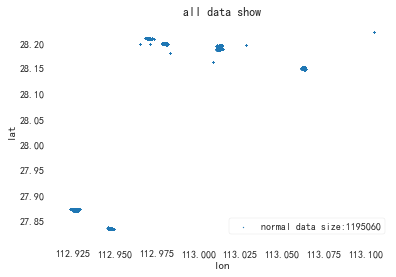

In [43]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
plt.title("all data show")
plt.xlabel("lon")
plt.ylabel("lat")
plt.legend()
plt.show()

## 全量数据噪声识别图形化展示

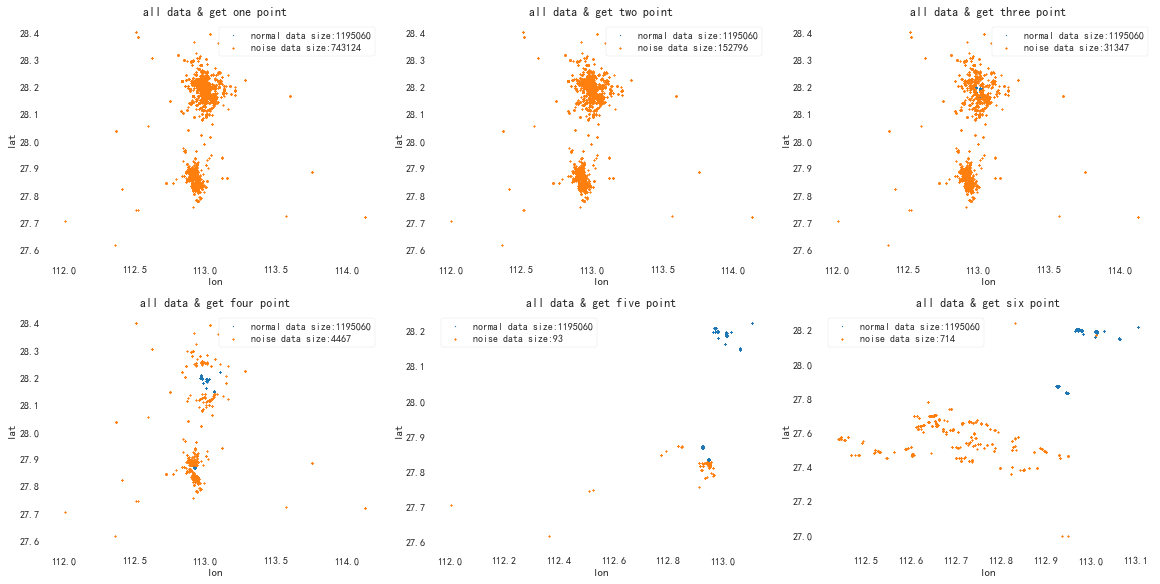

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

fig_3, axs_3 = plt.subplots(2, 3, figsize=(16, 8),constrained_layout=True)
axs_3[0, 0].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[0, 0].scatter(data_score_1["lon"],data_score_1["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_1.shape[0])
axs_3[0, 0].set_title("all data & get one point")
axs_3[0, 0].set_xlabel("lon")
axs_3[0, 0].set_ylabel("lat")
axs_3[0, 0].legend()

axs_3[0, 1].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[0, 1].scatter(data_score_2["lon"],data_score_2["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_2.shape[0])
axs_3[0, 1].set_title("all data & get two point")
axs_3[0, 1].set_xlabel("lon")
axs_3[0, 1].set_ylabel("lat")
axs_3[0, 1].legend()

axs_3[0, 2].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[0, 2].scatter(data_score_3["lon"],data_score_3["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_3.shape[0])
axs_3[0, 2].set_title("all data & get three point")
axs_3[0, 2].set_xlabel("lon")
axs_3[0, 2].set_ylabel("lat")
axs_3[0, 2].legend()

axs_3[1, 0].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[1, 0].scatter(data_score_4["lon"],data_score_4["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_4.shape[0])
axs_3[1, 0].set_title("all data & get four point")
axs_3[1, 0].set_xlabel("lon")
axs_3[1, 0].set_ylabel("lat")
axs_3[1, 0].legend()

axs_3[1, 1].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[1, 1].scatter(data_score_5["lon"],data_score_5["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_5.shape[0])
axs_3[1, 1].set_title("all data & get five point")
axs_3[1, 1].set_xlabel("lon")
axs_3[1, 1].set_ylabel("lat")
axs_3[1, 1].legend()

axs_3[1, 2].scatter(data_score_normal["lon"],data_score_normal["lat"],s=normal_point_size,label="normal data size:%s"%data_score_normal.shape[0])
axs_3[1, 2].scatter(data_score_6["lon"],data_score_6["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%data_score_6.shape[0])
axs_3[1, 2].set_title("all data & get six point")
axs_3[1, 2].set_xlabel("lon")
axs_3[1, 2].set_ylabel("lat")
axs_3[1, 2].legend()


# 各cellid数据作为组合模型的输入

In [35]:
#获取需要单独训练的cellid
df_cnt=data.groupby(["cellid"]).count()
cnt_data = pd.DataFrame(df_cnt).sort_values(by=["lon"],ascending=False)
goal_cellid=list(cnt_data.index)
count=1
#取数量最多的top9的cellid数据进行训练展示
for i,cellid in  enumerate(goal_cellid[:9]):
        train_data_cellid=data[data["cellid"]==cellid]
        # profile = pandas_profiling.ProfileReport(train_data_cellid[origin_tain_column])
        # profile.to_file("output_file_%s.html"%cellid)
        # train_data_cellid.to_csv("cellid_data_%s.csv"%(i))
        print(train_data_cellid.shape)
        cellid_data_with_tab=train_union_model(train_data=train_data_cellid,origin_tain_column=origin_tain_column,noisy_thread=noisy_thread,mode=2)
        if count==1:
            total_data_with_lab = cellid_data_with_tab.copy()
            count=0
        else:
            total_data_with_lab = pd.concat([total_data_with_lab, cellid_data_with_tab], axis=0, ignore_index=True)
            
total_data_with_lab["total_scores"]=total_data_with_lab["IForest_lab"]+total_data_with_lab["LOF_lab"]+total_data_with_lab["KNN_lab"]+total_data_with_lab["HBOS_lab"]
# +total_data_with_lab["MCD_lab"]+total_data_with_lab["FB_lab"]
total_data_with_lab.to_csv("total_scores_every_cellid_%s_col.csv"%len(origin_tain_column),index=False)

(304364, 18)
KNN Over
IForest over
LOF over
HBOS Over
(258268, 18)
KNN Over
IForest over
LOF over
HBOS Over
(226244, 18)
KNN Over
IForest over
LOF over
HBOS Over
(222296, 18)
KNN Over
IForest over
LOF over
HBOS Over
(212446, 18)
KNN Over
IForest over
LOF over
HBOS Over
(198173, 18)
KNN Over
IForest over
LOF over
HBOS Over
(196857, 18)
KNN Over
IForest over
LOF over
HBOS Over
(163512, 18)
KNN Over
IForest over
LOF over
HBOS Over
(156024, 18)
KNN Over
IForest over
LOF over
HBOS Over


In [19]:
#获取需要单独训练的cellid
df_cnt=data.groupby(["cellid"]).count()
cnt_data = pd.DataFrame(df_cnt).sort_values(by=["lon"],ascending=False)
goal_cellid=list(cnt_data.index)

data = pd.read_csv("total_scores_every_cellid_%s_col.csv"%len(origin_tain_column))

data_cellid_0=data[data["cellid"]==goal_cellid[0]]
data_cellid_1=data[data["cellid"]==goal_cellid[1]]
data_cellid_2=data[data["cellid"]==goal_cellid[2]]
data_cellid_3=data[data["cellid"]==goal_cellid[3]]
data_cellid_4=data[data["cellid"]==goal_cellid[4]]
data_cellid_5=data[data["cellid"]==goal_cellid[5]]
data_cellid_6=data[data["cellid"]==goal_cellid[6]]
data_cellid_7=data[data["cellid"]==goal_cellid[7]]
data_cellid_8=data[data["cellid"]==goal_cellid[8]]

In [20]:
import matplotlib.pyplot as plt
import numpy as np

thread_num=1

normal_data_0=data_cellid_0[data_cellid_0["total_scores"]==0]
noise_data_0=data_cellid_0[data_cellid_0["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_0["cellid"].head(1).values))
print(data_cellid_0.shape)
print("正常数据量:%s"%normal_data_0.shape[0])
print("噪声数据量:%s"%noise_data_0.shape[0])
print("*"*20)

normal_data_1=data_cellid_1[data_cellid_1["total_scores"]==0]
noise_data_1=data_cellid_1[data_cellid_1["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_1["cellid"].head(1).values))
print(data_cellid_1.shape)
print("正常数据量:%s"%normal_data_1.shape[0])
print("噪声数据量:%s"%noise_data_1.shape[0])
print("*"*20)

normal_data_2=data_cellid_2[data_cellid_2["total_scores"]==0]
noise_data_2=data_cellid_2[data_cellid_2["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_2["cellid"].head(1).values))
print(data_cellid_2.shape)
print("正常数据量:%s"%normal_data_2.shape[0])
print("噪声数据量:%s"%noise_data_2.shape[0])
print("*"*20)

normal_data_3=data_cellid_3[data_cellid_3["total_scores"]==0]
noise_data_3=data_cellid_3[data_cellid_3["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_3["cellid"].head(1).values))
print(data_cellid_3.shape)
print("正常数据量:%s"%normal_data_3.shape[0])
print("噪声数据量:%s"%noise_data_3.shape[0])
print("*"*20)

normal_data_4=data_cellid_4[data_cellid_4["total_scores"]==0]
noise_data_4=data_cellid_4[data_cellid_4["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_4["cellid"].head(1).values))
print(data_cellid_4.shape)
print("正常数据量:%s"%normal_data_4.shape[0])
print("噪声数据量:%s"%noise_data_4.shape[0])
print("*"*20)

normal_data_5=data_cellid_5[data_cellid_5["total_scores"]==0]
noise_data_5=data_cellid_5[data_cellid_5["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_5["cellid"].head(1).values))
print(data_cellid_5.shape)
print("正常数据量:%s"%normal_data_5.shape[0])
print("噪声数据量:%s"%noise_data_5.shape[0])
print("*"*20)

normal_data_6=data_cellid_6[data_cellid_6["total_scores"]==0]
noise_data_6=data_cellid_6[data_cellid_6["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_6["cellid"].head(1).values))
print(data_cellid_6.shape)
print("正常数据量:%s"%normal_data_6.shape[0])
print("噪声数据量:%s"%noise_data_6.shape[0])
print("*"*20)

normal_data_7=data_cellid_7[data_cellid_7["total_scores"]==0]
noise_data_7=data_cellid_7[data_cellid_7["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_7["cellid"].head(1).values))
print(data_cellid_7.shape)
print("正常数据量:%s"%normal_data_7.shape[0])
print("噪声数据量:%s"%noise_data_7.shape[0])
print("*"*20)

normal_data_8=data_cellid_8[data_cellid_8["total_scores"]==0]
noise_data_8=data_cellid_8[data_cellid_8["total_scores"]>thread_num]
print("cellid 为：%s"%(normal_data_8["cellid"].head(1).values))
print(data_cellid_8.shape)
print("正常数据量:%s"%normal_data_8.shape[0])
print("噪声数据量:%s"%noise_data_8.shape[0])
print("*"*20)


cellid 为：['11075584-1037108']
(304364, 18)
正常数据量:242695
噪声数据量:22265
********************
cellid 为：['8167400-384509']
(258268, 18)
正常数据量:208596
噪声数据量:20021
********************
cellid 为：['2334696-389475']
(226244, 18)
正常数据量:181099
噪声数据量:17594
********************
cellid 为：['11666708-533434']
(222296, 18)
正常数据量:172997
噪声数据量:13503
********************
cellid 为：['17145832-394108']
(212446, 18)
正常数据量:169622
噪声数据量:16713
********************
cellid 为：['11075584-1037102']
(198173, 18)
正常数据量:159075
噪声数据量:16408
********************
cellid 为：['4233254-459559']
(196857, 18)
正常数据量:170651
噪声数据量:15703
********************
cellid 为：['696296-389644']
(163512, 18)
正常数据量:129398
噪声数据量:11341
********************
cellid 为：['11075584-464035']
(156024, 18)
正常数据量:124770
噪声数据量:12600
********************


## 单个cellid噪声识别效果展示

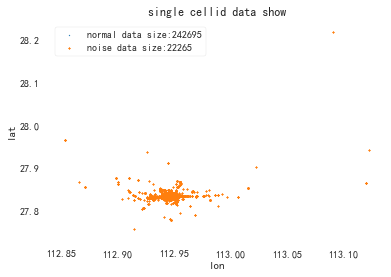

In [38]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(normal_data_0["lon"],normal_data_0["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_0.shape[0])
plt.scatter(noise_data_0["lon"],noise_data_0["lat"],marker="x",s=normal_point_size,label="noise data size:%s"%noise_data_0.shape[0])
plt.title("single cellid data show")
plt.xlabel("lon")
plt.ylabel("lat")
plt.legend()
plt.show()

## 9组cellid正常数据的展示

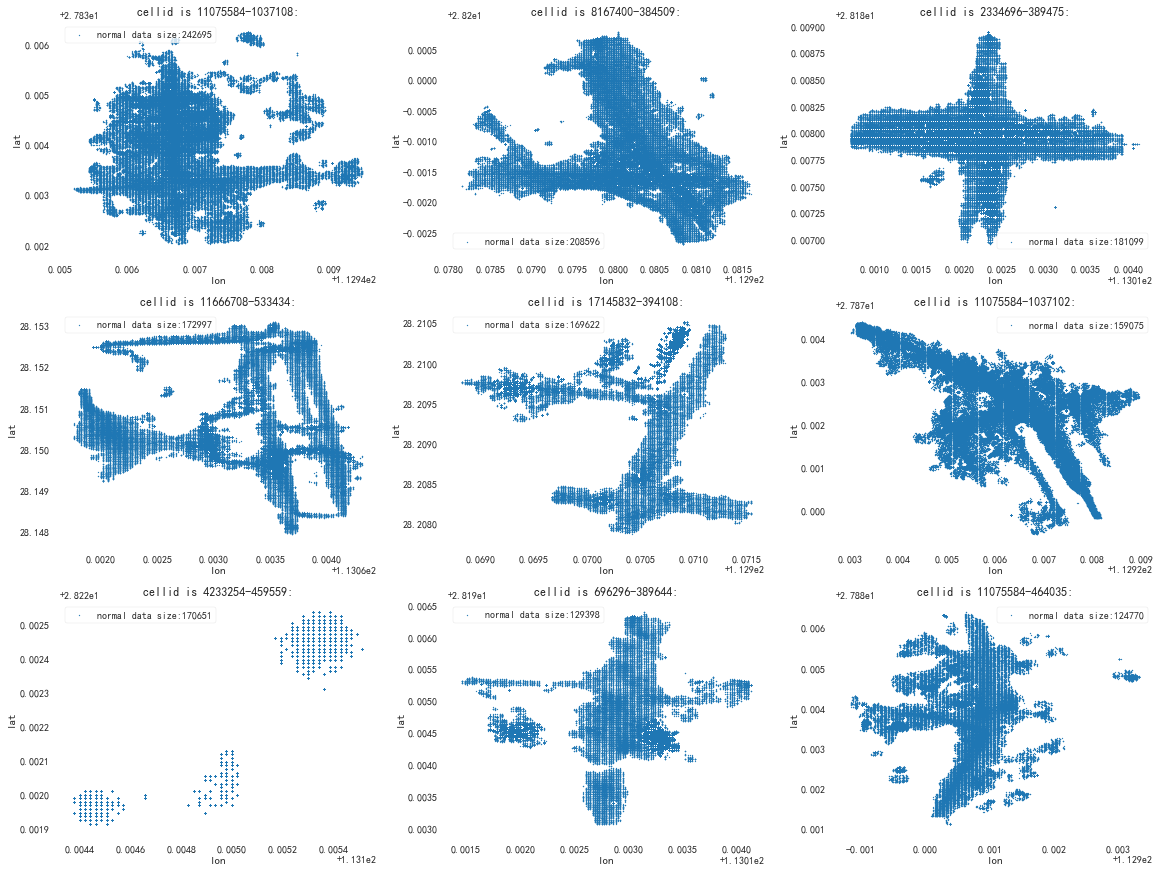

In [39]:
fig_4, axs_4 = plt.subplots(3, 3, figsize=(16, 12),constrained_layout=True)
axs_4[0, 0].scatter(normal_data_0["lon"],normal_data_0["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_0.shape[0])
axs_4[0, 0].set_title("cellid is %s:"%(normal_data_0["cellid"].head(1).values[0]))
axs_4[0, 0].set_xlabel("lon")
axs_4[0, 0].set_ylabel("lat")
axs_4[0, 0].legend()

axs_4[0, 1].scatter(normal_data_1["lon"],normal_data_1["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_1.shape[0])
axs_4[0, 1].set_title("cellid is %s:"%(normal_data_1["cellid"].head(1).values[0]))
axs_4[0, 1].set_xlabel("lon")
axs_4[0, 1].set_ylabel("lat")
axs_4[0, 1].legend()

axs_4[0, 2].scatter(normal_data_2["lon"],normal_data_2["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_2.shape[0])
axs_4[0, 2].set_title("cellid is %s:"%(normal_data_2["cellid"].head(1).values[0]))
axs_4[0, 2].set_xlabel("lon")
axs_4[0, 2].set_ylabel("lat")
axs_4[0, 2].legend()

axs_4[1, 0].scatter(normal_data_3["lon"],normal_data_3["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_3.shape[0])
axs_4[1, 0].set_title("cellid is %s:"%(normal_data_3["cellid"].head(1).values[0]))
axs_4[1, 0].set_xlabel("lon")
axs_4[1, 0].set_ylabel("lat")
axs_4[1, 0].legend()

axs_4[1, 1].scatter(normal_data_4["lon"],normal_data_4["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_4.shape[0])
axs_4[1, 1].set_title("cellid is %s:"%(normal_data_4["cellid"].head(1).values[0]))
axs_4[1, 1].set_xlabel("lon")
axs_4[1, 1].set_ylabel("lat")
axs_4[1, 1].legend()

axs_4[1, 2].scatter(normal_data_5["lon"],normal_data_5["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_5.shape[0])
axs_4[1, 2].set_title("cellid is %s:"%(normal_data_5["cellid"].head(1).values[0]))
axs_4[1, 2].set_xlabel("lon")
axs_4[1, 2].set_ylabel("lat")
axs_4[1, 2].legend()

axs_4[2, 0].scatter(normal_data_6["lon"],normal_data_6["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_6.shape[0])
axs_4[2, 0].set_title("cellid is %s:"%(normal_data_6["cellid"].head(1).values[0]))
axs_4[2, 0].set_xlabel("lon")
axs_4[2, 0].set_ylabel("lat")
axs_4[2, 0].legend()

axs_4[2, 1].scatter(normal_data_7["lon"],normal_data_7["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_7.shape[0])
axs_4[2, 1].set_title("cellid is %s:"%(normal_data_7["cellid"].head(1).values[0]))
axs_4[2, 1].set_xlabel("lon")
axs_4[2, 1].set_ylabel("lat")
axs_4[2, 1].legend()


axs_4[2,2].scatter(normal_data_8["lon"],normal_data_8["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_8.shape[0])
axs_4[2,2].set_title("cellid is %s:"%(normal_data_8["cellid"].head(1).values[0]))
axs_4[2,2].set_xlabel("lon")
axs_4[2,2].set_ylabel("lat")
axs_4[2,2].legend()

## 9组cellid数据的密度图

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


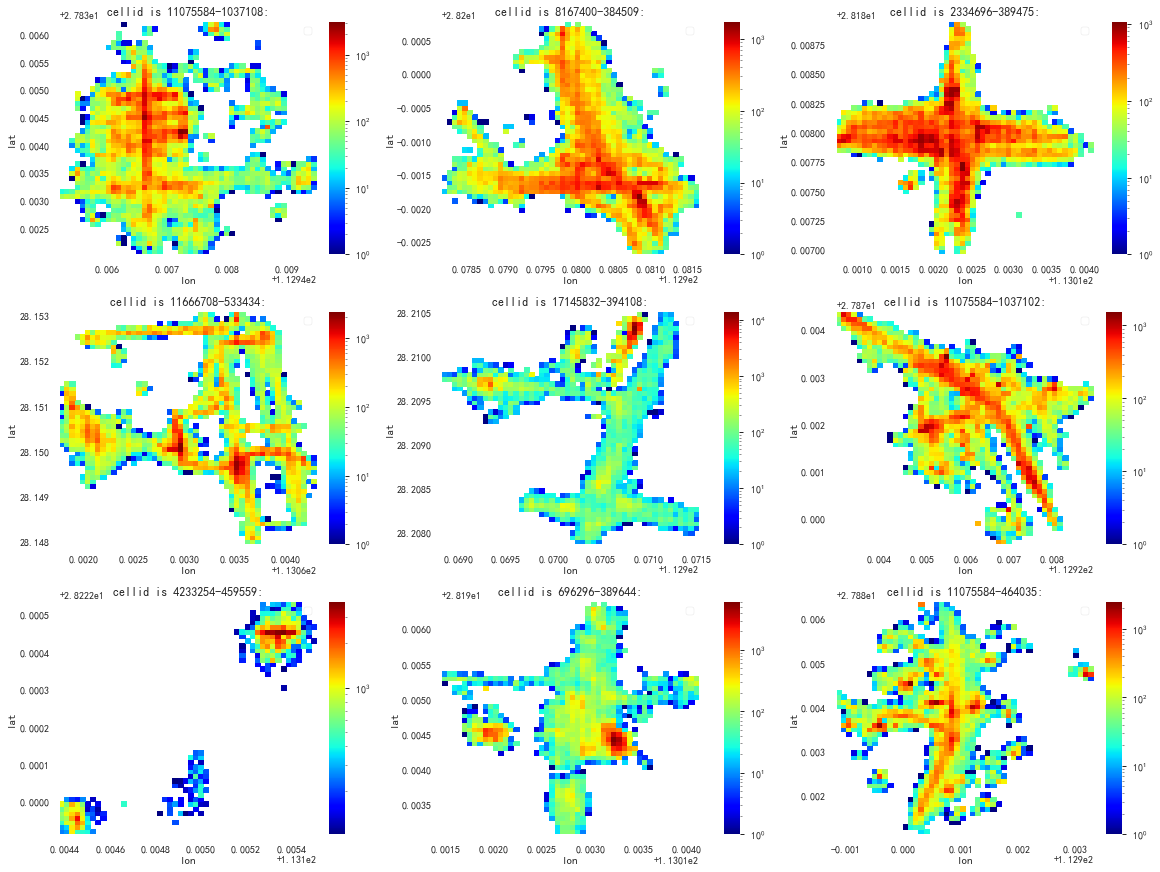

In [24]:
fig_4, axs_4 = plt.subplots(3, 3, figsize=(16, 12),constrained_layout=True)

counts, xedges, yedges, im = axs_4[0, 0].hist2d(normal_data_0["lon"],normal_data_0["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_0.shape[0])
axs_4[0, 0].set_title("cellid is %s:"%(normal_data_0["cellid"].head(1).values[0]))
axs_4[0, 0].set_xlabel("lon")
axs_4[0, 0].set_ylabel("lat")
axs_4[0, 0].legend()
plt.colorbar(im, ax=axs_4[0, 0])


counts, xedges, yedges, im = axs_4[0, 1].hist2d(normal_data_1["lon"],normal_data_1["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_1.shape[0])
axs_4[0, 1].set_title("cellid is %s:"%(normal_data_1["cellid"].head(1).values[0]))
axs_4[0, 1].set_xlabel("lon")
axs_4[0, 1].set_ylabel("lat")
axs_4[0, 1].legend()
plt.colorbar(im, ax=axs_4[0, 1])

counts, xedges, yedges, im =axs_4[0, 2].hist2d(normal_data_2["lon"],normal_data_2["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_2.shape[0])
axs_4[0, 2].set_title("cellid is %s:"%(normal_data_2["cellid"].head(1).values[0]))
axs_4[0, 2].set_xlabel("lon")
axs_4[0, 2].set_ylabel("lat")
axs_4[0, 2].legend()
plt.colorbar(im, ax=axs_4[0, 2])

counts, xedges, yedges, im =axs_4[1, 0].hist2d(normal_data_3["lon"],normal_data_3["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_3.shape[0])
axs_4[1, 0].set_title("cellid is %s:"%(normal_data_3["cellid"].head(1).values[0]))
axs_4[1, 0].set_xlabel("lon")
axs_4[1, 0].set_ylabel("lat")
axs_4[1, 0].legend()
plt.colorbar(im, ax=axs_4[1, 0])

counts, xedges, yedges, im =axs_4[1, 1].hist2d(normal_data_4["lon"],normal_data_4["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_4.shape[0])
axs_4[1, 1].set_title("cellid is %s:"%(normal_data_4["cellid"].head(1).values[0]))
axs_4[1, 1].set_xlabel("lon")
axs_4[1, 1].set_ylabel("lat")
axs_4[1, 1].legend()
plt.colorbar(im, ax=axs_4[1, 1])

counts, xedges, yedges, im =axs_4[1, 2].hist2d(normal_data_5["lon"],normal_data_5["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_5.shape[0])
axs_4[1, 2].set_title("cellid is %s:"%(normal_data_5["cellid"].head(1).values[0]))
axs_4[1, 2].set_xlabel("lon")
axs_4[1, 2].set_ylabel("lat")
axs_4[1, 2].legend()
plt.colorbar(im, ax=axs_4[1, 2])

counts, xedges, yedges, im =axs_4[2, 0].hist2d(normal_data_6["lon"],normal_data_6["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_6.shape[0])
axs_4[2, 0].set_title("cellid is %s:"%(normal_data_6["cellid"].head(1).values[0]))
axs_4[2, 0].set_xlabel("lon")
axs_4[2, 0].set_ylabel("lat")
axs_4[2, 0].legend()
plt.colorbar(im, ax=axs_4[2, 0])

counts, xedges, yedges, im =axs_4[2, 1].hist2d(normal_data_7["lon"],normal_data_7["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_7.shape[0])
axs_4[2, 1].set_title("cellid is %s:"%(normal_data_7["cellid"].head(1).values[0]))
axs_4[2, 1].set_xlabel("lon")
axs_4[2, 1].set_ylabel("lat")
axs_4[2, 1].legend()
plt.colorbar(im, ax=axs_4[2, 1])


counts, xedges, yedges, im =axs_4[2,2].hist2d(normal_data_8["lon"],normal_data_8["lat"],bins=50,norm=LogNorm(),cmap=plt.get_cmap("jet"),label="normal data size:%s"%normal_data_8.shape[0])
axs_4[2,2].set_title("cellid is %s:"%(normal_data_8["cellid"].head(1).values[0]))
axs_4[2,2].set_xlabel("lon")
axs_4[2,2].set_ylabel("lat")
axs_4[2,2].legend()
plt.colorbar(im, ax=axs_4[2, 2])



## 九组cellid数据的噪声识别效果展示

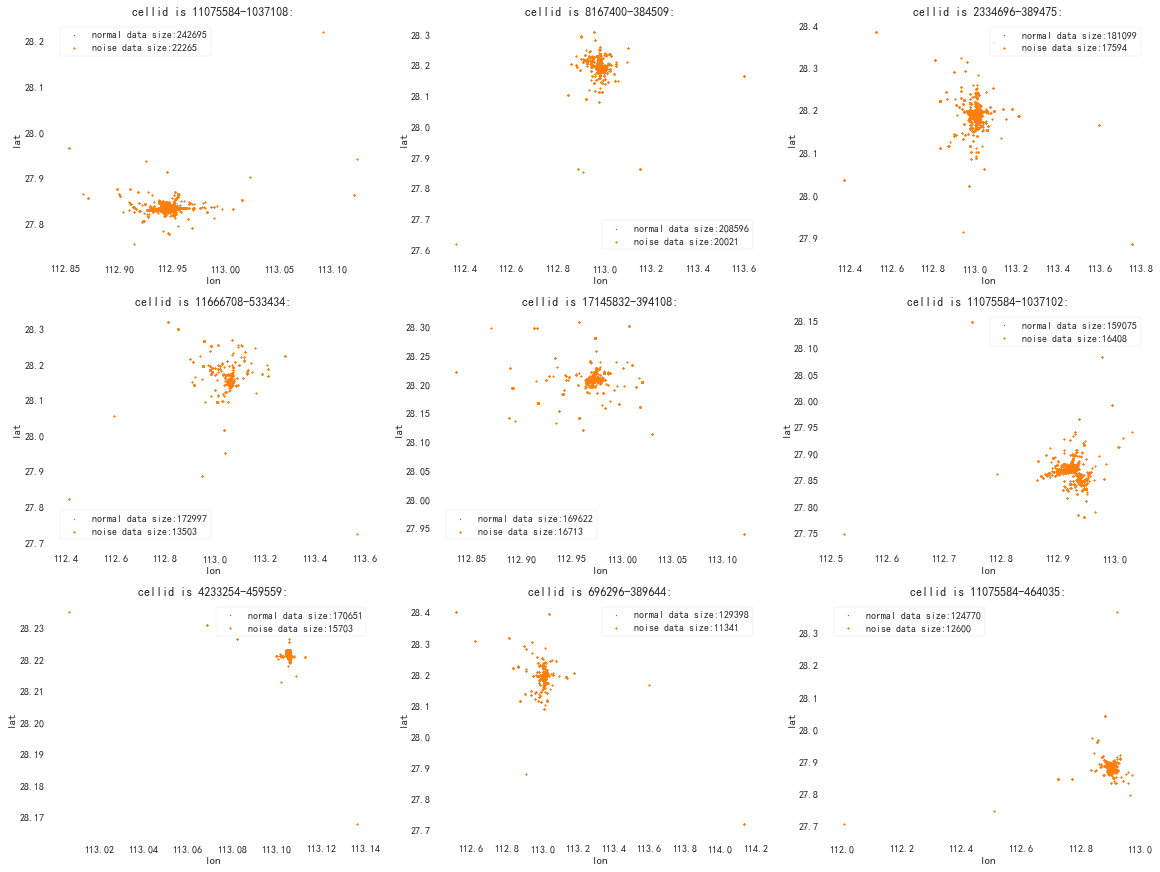

In [21]:
fig_3, axs_3 = plt.subplots(3, 3, figsize=(16, 12),constrained_layout=True)
axs_3[0, 0].scatter(normal_data_0["lon"],normal_data_0["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_0.shape[0])
axs_3[0, 0].scatter(noise_data_0["lon"],noise_data_0["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_0.shape[0])
axs_3[0, 0].set_title("cellid is %s:"%(normal_data_0["cellid"].head(1).values[0]))
axs_3[0, 0].set_xlabel("lon")
axs_3[0, 0].set_ylabel("lat")
axs_3[0, 0].legend()

axs_3[0, 1].scatter(normal_data_1["lon"],normal_data_1["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_1.shape[0])
axs_3[0, 1].scatter(noise_data_1["lon"],noise_data_1["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_1.shape[0])
axs_3[0, 1].set_title("cellid is %s:"%(normal_data_1["cellid"].head(1).values[0]))
axs_3[0, 1].set_xlabel("lon")
axs_3[0, 1].set_ylabel("lat")
axs_3[0, 1].legend()

axs_3[0, 2].scatter(normal_data_2["lon"],normal_data_2["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_2.shape[0])
axs_3[0, 2].scatter(noise_data_2["lon"],noise_data_2["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_2.shape[0])
axs_3[0, 2].set_title("cellid is %s:"%(normal_data_2["cellid"].head(1).values[0]))
axs_3[0, 2].set_xlabel("lon")
axs_3[0, 2].set_ylabel("lat")
axs_3[0, 2].legend()

axs_3[1, 0].scatter(normal_data_3["lon"],normal_data_3["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_3.shape[0])
axs_3[1, 0].scatter(noise_data_3["lon"],noise_data_3["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_3.shape[0])
axs_3[1, 0].set_title("cellid is %s:"%(normal_data_3["cellid"].head(1).values[0]))
axs_3[1, 0].set_xlabel("lon")
axs_3[1, 0].set_ylabel("lat")
axs_3[1, 0].legend()

axs_3[1, 1].scatter(normal_data_4["lon"],normal_data_4["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_4.shape[0])
axs_3[1, 1].scatter(noise_data_4["lon"],noise_data_4["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_4.shape[0])
axs_3[1, 1].set_title("cellid is %s:"%(normal_data_4["cellid"].head(1).values[0]))
axs_3[1, 1].set_xlabel("lon")
axs_3[1, 1].set_ylabel("lat")
axs_3[1, 1].legend()

axs_3[1, 2].scatter(normal_data_5["lon"],normal_data_5["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_5.shape[0])
axs_3[1, 2].scatter(noise_data_5["lon"],noise_data_5["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_5.shape[0])
axs_3[1, 2].set_title("cellid is %s:"%(normal_data_5["cellid"].head(1).values[0]))
axs_3[1, 2].set_xlabel("lon")
axs_3[1, 2].set_ylabel("lat")
axs_3[1, 2].legend()

axs_3[2, 0].scatter(normal_data_6["lon"],normal_data_6["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_6.shape[0])
axs_3[2, 0].scatter(noise_data_6["lon"],noise_data_6["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_6.shape[0])
axs_3[2, 0].set_title("cellid is %s:"%(normal_data_6["cellid"].head(1).values[0]))
axs_3[2, 0].set_xlabel("lon")
axs_3[2, 0].set_ylabel("lat")
axs_3[2, 0].legend()

axs_3[2, 1].scatter(normal_data_7["lon"],normal_data_7["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_7.shape[0])
axs_3[2, 1].scatter(noise_data_7["lon"],noise_data_7["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_7.shape[0])
axs_3[2, 1].set_title("cellid is %s:"%(normal_data_7["cellid"].head(1).values[0]))
axs_3[2, 1].set_xlabel("lon")
axs_3[2, 1].set_ylabel("lat")
axs_3[2, 1].legend()


axs_3[2,2].scatter(normal_data_8["lon"],normal_data_8["lat"],s=normal_point_size,label="normal data size:%s"%normal_data_8.shape[0])
axs_3[2,2].scatter(noise_data_8["lon"],noise_data_8["lat"],marker="x",s=noise_point_size,label="noise data size:%s"%noise_data_8.shape[0])
axs_3[2,2].set_title("cellid is %s:"%(normal_data_8["cellid"].head(1).values[0]))
axs_3[2,2].set_xlabel("lon")
axs_3[2,2].set_ylabel("lat")
axs_3[2,2].legend()

## 分组cellid噪声识别数据的并集

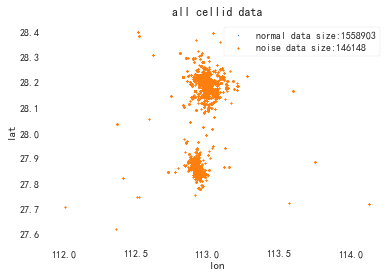

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


cellid_normal_data_all=total_data_with_lab[total_data_with_lab["total_scores"]==0]
cellid_noise_data_all=total_data_with_lab[total_data_with_lab["total_scores"]>thread_num]
plt.scatter(cellid_normal_data_all["lon"],cellid_normal_data_all["lat"],label="normal data size:%s"%cellid_normal_data_all.shape[0],s=normal_point_size)
plt.scatter(cellid_noise_data_all["lon"],cellid_noise_data_all["lat"],marker="x",label="noise data size:%s"%cellid_noise_data_all.shape[0],s=noise_point_size)
plt.title("all cellid data")
# plt.rcParams['figure.figsize'] = (9, 6)
plt.xlabel("lon")
plt.ylabel("lat")
plt.legend()
# plt.show()